# SPINN NF2
> NF2 + SPINN

In [ ]:
import os

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [ ]:
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

## Input data

In [ ]:
import json

In [ ]:
with open('config.json') as config:
    info = json.load(config)

nx = info['nx']
ny = info['ny']
nz = info['nz']
b_norm = info['b_norm']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [ ]:
from zpinn.pinn_nf2_cleanup import create_coordinates

/userhome/jeon_mg/mambaforge/envs/pinf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
with open("bv.pickle","rb") as f:
    bv = pickle.load(f)

with open("b_bottom.pickle","rb") as f:
    b_bottom = pickle.load(f)

with open("bp_top.pickle","rb") as f:
    bp_top = pickle.load(f)

with open("bp_lateral_1.pickle","rb") as f:
    bp_lateral_1 = pickle.load(f)

with open("bp_lateral_2.pickle","rb") as f:
    bp_lateral_2 = pickle.load(f)

with open("bp_lateral_3.pickle","rb") as f:
    bp_lateral_3 = pickle.load(f)

with open("bp_lateral_4.pickle","rb") as f:
    bp_lateral_4 = pickle.load(f)

# Model

In [ ]:
import jax 
import jax.numpy as jnp
from jax import jvp
import optax
from flax import linen as nn 

from typing import Sequence
from functools import partial

import time
from tqdm import trange

In [ ]:
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out
    
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

In [ ]:
class SPINN3d(nn.Module):
    features: Sequence[int]
    r: int
    out_dim: int
    pos_enc: int
    mlp: str

    @nn.compact
    def __call__(self, x, y, z):
        '''
        inputs: input factorized coordinates
        outputs: feature output of each body network
        xy: intermediate tensor for feature merge btw. x and y axis
        pred: final model prediction (e.g. for 2d output, pred=[u, v])
        '''
        if self.pos_enc != 0:
            # positional encoding only to spatial coordinates
            freq = jnp.expand_dims(jnp.arange(1, self.pos_enc+1, 1), 0)
            y = jnp.concatenate((jnp.ones((y.shape[0], 1)), jnp.sin(y@freq), jnp.cos(y@freq)), 1)
            z = jnp.concatenate((jnp.ones((z.shape[0], 1)), jnp.sin(z@freq), jnp.cos(z@freq)), 1)

            # causal PINN version (also on time axis)
            #  freq_x = jnp.expand_dims(jnp.power(10.0, jnp.arange(0, 3)), 0)
            # x = x@freq_x
            
        inputs, outputs, xy, pred = [x, y, z], [], [], []
        init = nn.initializers.glorot_normal()

        if self.mlp == 'mlp':
            for X in inputs:
                for fs in self.features[:-1]:
                    X = nn.Dense(fs, kernel_init=init)(X)
                    X = nn.activation.tanh(X)
                X = nn.Dense(self.r*self.out_dim, kernel_init=init)(X)
                outputs += [jnp.transpose(X, (1, 0))]

        elif self.mlp == 'modified_mlp':
            for X in inputs:
                U = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                V = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                H = nn.activation.tanh(nn.Dense(self.features[0], kernel_init=init)(X))
                for fs in self.features[:-1]:
                    Z = nn.Dense(fs, kernel_init=init)(H)
                    Z = nn.activation.tanh(Z)
                    H = (jnp.ones_like(Z)-Z)*U + Z*V
                H = nn.Dense(self.r*self.out_dim, kernel_init=init)(H)
                outputs += [jnp.transpose(H, (1, 0))]
        
        for i in range(self.out_dim):
            xy += [jnp.einsum('fx, fy->fxy', outputs[0][self.r*i:self.r*(i+1)], outputs[1][self.r*i:self.r*(i+1)])]
            pred += [jnp.einsum('fxy, fz->xyz', xy[i], outputs[-1][self.r*i:self.r*(i+1)])]

        if len(pred) == 1:
            # 1-dimensional output
            return pred[0]
        else:
            # n-dimensional output
            return pred

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
features = 256 # feature size of each layer
n_layers = 8 # the number of layer
feat_sizes = tuple([features for _ in range(n_layers)]) # feature sizes
r = 128 # rank of a approximated tensor
out_dim = 3 # size of model output

lr = 5e-4 # learning rate

epochs = 2000 #10000
log_iter = 100 #1000

# Loss weight
# lbda_c = 100
# lbda_ic = 10

In [ ]:
@partial(jax.jit)
def generate_train_data():
#     keys = jax.random.split(key, 4)
    
    # collocation points
#     xc = jax.random.uniform(keys[1], (nc, 1), minval=0., maxval=2.)
#     yc = jax.random.uniform(keys[2], (nc, 1), minval=0., maxval=2.)
#     zc = jax.random.uniform(keys[3], (nc, 1), minval=0., maxval=2.)
    xc = jnp.linspace(0, 2, nx).reshape(nx, 1)
    yc = jnp.linspace(0, 2, ny).reshape(ny, 1)
    zc = jnp.linspace(0, 2, nz).reshape(nz, 1)

    # # boundary points
    xb = [jnp.linspace(0, 2, nx).reshape(nx, 1), # z=0   bottom
          jnp.linspace(0, 2, nx).reshape(nx, 1), # z=2   top
          jnp.array([[0.]]),                     # x=0   lateral_1
          jnp.array([[2.]]),                     # x=2   lateral_2
          jnp.linspace(0, 2, nx).reshape(nx, 1), # y=0   lateral_3
          jnp.linspace(0, 2, nx).reshape(nx, 1)] # y=2   lateral_4

    yb = [jnp.linspace(0, 2, ny).reshape(ny, 1), 
          jnp.linspace(0, 2, ny).reshape(ny, 1), 
          jnp.linspace(0, 2, ny).reshape(ny, 1), 
          jnp.linspace(0, 2, ny).reshape(ny, 1), 
          jnp.array([[0.]]), 
          jnp.array([[2.]])]

    zb = [jnp.array([[0.]]), 
          jnp.array([[2.]]), 
          jnp.linspace(0, 2, nz).reshape(nz, 1), 
          jnp.linspace(0, 2, nz).reshape(nz, 1), 
          jnp.linspace(0, 2, nz).reshape(nz, 1), 
          jnp.linspace(0, 2, nz).reshape(nz, 1)]

    return xc, yc, zc, xb, yb, zb

In [ ]:
def curlx(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_x = uz_y - uy_z
    vec_z = jnp.ones(z.shape)
    vec_y = jnp.ones(y.shape)
    uy_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec_z,))[1]
    uz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec_y,))[1]
    wx = uz_y - uy_z
    return wx


def curly(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_y = ux_z - uz_x
    vec_z = jnp.ones(z.shape)
    vec_x = jnp.ones(x.shape)
    ux_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec_z,))[1]
    uz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec_x,))[1]
    wy = ux_z - uz_x
    return wy

def curlz(apply_fn, params, x, y, z):
    # curl vector w/ forward-mode AD
    # w_z = uy_x - ux_y
    vec_y = jnp.ones(y.shape)
    vec_x = jnp.ones(x.shape)
    ux_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec_y,))[1]
    uy_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec_x,))[1]
    wz = uy_x - ux_y
    return wz


In [ ]:
@partial(jax.jit, static_argnums=(0,))
def apply_model_spinn(apply_fn, params, *train_data):
    def residual_loss(params, x, y, z):
        # calculate u
        Bx, By, Bz = apply_fn(params, x, y, z)
        B = jnp.stack([Bx, By, Bz], axis=-1)
        
        # calculate J
        Jx = curlx(apply_fn, params, x, y, z)
        Jy = curly(apply_fn, params, x, y, z)
        Jz = curlz(apply_fn, params, x, y, z)
        J = jnp.stack([Jx, Jy, Jz], axis=-1)

        JxB = jnp.cross(J, B, axis=-1) 

        #-----------------------------------------------------------
        loss_ff = jnp.sum(JxB**2, axis=-1) / (jnp.sum(B**2, axis=-1) + 1e-7)
        loss_ff = jnp.mean(loss_ff)

        # loss_ff = jnp.mean(JxB**2)

        # loss_ff = jnp.sum(JxB**2, axis=-1)
        # loss_ff = jnp.mean(loss_ff)
        #-----------------------------------------------------------

        # tangent vector dx/dx
        # assumes x, y, z have same shape (very important)
        vec_x = jnp.ones(x.shape)
        vec_y = jnp.ones(y.shape)
        vec_z = jnp.ones(z.shape)
        
        Bx_x = jvp(lambda x: apply_fn(params, x, y, z)[0], (x,), (vec_x,))[1]
        # Bx_y = jvp(lambda y: apply_fn(params, x, y, z)[0], (y,), (vec,))[1]
        # Bx_z = jvp(lambda z: apply_fn(params, x, y, z)[0], (z,), (vec,))[1]

        # By_x = jvp(lambda x: apply_fn(params, x, y, z)[1], (x,), (vec,))[1]
        By_y = jvp(lambda y: apply_fn(params, x, y, z)[1], (y,), (vec_y,))[1]
        # By_z = jvp(lambda z: apply_fn(params, x, y, z)[1], (z,), (vec,))[1]

        # Bz_x = jvp(lambda x: apply_fn(params, x, y, z)[2], (x,), (vec,))[1]
        # Bz_y = jvp(lambda y: apply_fn(params, x, y, z)[2], (y,), (vec,))[1]
        Bz_z = jvp(lambda z: apply_fn(params, x, y, z)[2], (z,), (vec_z,))[1]

        divB = Bx_x + By_y + Bz_z
        
        #-----------------------------------------------------------
        # loss_div = jnp.sum((divB)**2, axis=-1)
        # loss_div = jnp.mean(loss_div)

        loss_div = jnp.mean((divB)**2)
        #-----------------------------------------------------------

        loss = loss_ff + loss_div

        return loss

    def boundary_loss(params, x, y, z):
        
        # loss = 0.
        # for i in np.arange(4):
        #     boundary_data_batched = boundary_batches[i, :, :, :]
        #     xb = boundary_data_batched[:, 0, :][:, 0].reshape(-1, 1)
        #     yb = boundary_data_batched[:, 0, :][:, 1].reshape(-1, 1)
        #     zb = boundary_data_batched[:, 0, :][:, 2].reshape(-1, 1)

        #     Bx, By, Bz = apply_fn(params, xb, yb, zb)
        #     # Bx, By, Bz = Bx.reshape(-1, 1), By.reshape(-1, 1), Bz.reshape(-1, 1)

        #     Bxb = boundary_data_batched[:, 1, :][:, 0].reshape(-1, 1)
        #     Byb = boundary_data_batched[:, 1, :][:, 1].reshape(-1, 1)
        #     Bzb = boundary_data_batched[:, 1, :][:, 2].reshape(-1, 1)

        #     Bxb_mesh, Byb_mesh, Bzb_mesh = jnp.meshgrid(Bxb.ravel(), Byb.ravel(), Bzb.ravel(), indexing='ij')
            
        #     loss += jnp.mean((Bx - Bxb_mesh)**2) + jnp.mean((By - Byb_mesh)**2) + jnp.mean((Bz - Bzb_mesh)**2)

        #0 z=0   bottom
        #1 z=2   top
        #2 x=0   lateral_1
        #3 x=2   lateral_2
        #4 y=0   lateral_3
        #5 y=2   lateral_4
        

        loss = 0.
        Bx, By, Bz = apply_fn(params,  x[0], y[0], z[0])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - b_bottom[:, :, 0])**2) + jnp.mean((By - b_bottom[:, :, 1])**2) + jnp.mean((Bz - b_bottom[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[1], y[1], z[1])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - bp_top[:, :, 0])**2) + jnp.mean((By - bp_top[:, :, 1])**2) + jnp.mean((Bz - bp_top[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[2], y[2], z[2])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - bp_lateral_1[:, :, 0])**2) + jnp.mean((By - bp_lateral_1[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_1[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[3], y[3], z[3])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - bp_lateral_2[:, :, 0])**2) + jnp.mean((By - bp_lateral_2[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_2[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[4], y[4], z[4])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - bp_lateral_3[:, :, 0])**2) + jnp.mean((By - bp_lateral_3[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_3[:, :, 2])**2)

        Bx, By, Bz = apply_fn(params,  x[5], y[5], z[5])
        Bx, By, Bz = jnp.squeeze(Bx), jnp.squeeze(By), jnp.squeeze(Bz)
        loss += jnp.mean((Bx - bp_lateral_4[:, :, 0])**2) + jnp.mean((By - bp_lateral_4[:, :, 1])**2) + jnp.mean((Bz - bp_lateral_4[:, :, 2])**2)

        
        return loss

    # unpack data
    xc, yc, zc, xb, yb, zb = train_data

    # isolate loss func from redundant arguments
    loss_fn = lambda params: residual_loss(params, xc, yc, zc) + boundary_loss(params, xb, yb, zb)

    loss, gradient = jax.value_and_grad(loss_fn)(params)

    return loss, gradient

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='modified_mlp')
params = model.init(
            subkey,
            jnp.ones((nx, 1)),
            jnp.ones((ny, 1)),
            jnp.ones((nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data()

complie (it takes time)

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, *train_data)
params, state = update_model(optim, gradient, params, state)

In [ ]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 1000 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     train_data = generate_train_data(nc, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, *train_data)
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0 or e == 1:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

  0%|          | 4/2000 [00:00<01:05, 30.47it/s]

Epoch: 1/2000 --> total loss: 0.22961210


  5%|▌         | 104/2000 [00:04<01:19, 23.97it/s]

Epoch: 100/2000 --> total loss: 0.21564636


 10%|█         | 204/2000 [00:08<01:13, 24.47it/s]

Epoch: 200/2000 --> total loss: 0.14478752


 15%|█▌        | 304/2000 [00:12<01:09, 24.46it/s]

Epoch: 300/2000 --> total loss: 0.07186643


 20%|██        | 404/2000 [00:16<01:05, 24.40it/s]

Epoch: 400/2000 --> total loss: 0.01699475


 25%|██▌       | 504/2000 [00:21<01:01, 24.43it/s]

Epoch: 500/2000 --> total loss: 0.00916105


 30%|███       | 604/2000 [00:25<00:57, 24.42it/s]

Epoch: 600/2000 --> total loss: 0.00652192


 35%|███▌      | 704/2000 [00:29<00:52, 24.49it/s]

Epoch: 700/2000 --> total loss: 0.00519136


 40%|████      | 804/2000 [00:33<00:48, 24.48it/s]

Epoch: 800/2000 --> total loss: 0.00413873


 45%|████▌     | 904/2000 [00:37<00:44, 24.48it/s]

Epoch: 900/2000 --> total loss: 0.00340572


 50%|█████     | 1004/2000 [00:42<00:40, 24.48it/s]

Epoch: 1000/2000 --> total loss: 0.00318514


 55%|█████▌    | 1104/2000 [00:46<00:36, 24.42it/s]

Epoch: 1100/2000 --> total loss: 0.00456646


 60%|██████    | 1204/2000 [00:50<00:32, 24.44it/s]

Epoch: 1200/2000 --> total loss: 0.00299747


 65%|██████▌   | 1304/2000 [00:54<00:28, 24.42it/s]

Epoch: 1300/2000 --> total loss: 0.00279163


 70%|███████   | 1404/2000 [00:58<00:24, 24.44it/s]

Epoch: 1400/2000 --> total loss: 0.00252765


 75%|███████▌  | 1504/2000 [01:02<00:20, 24.42it/s]

Epoch: 1500/2000 --> total loss: 0.00240836


 80%|████████  | 1604/2000 [01:07<00:16, 24.42it/s]

Epoch: 1600/2000 --> total loss: 0.00232492


 85%|████████▌ | 1704/2000 [01:11<00:12, 24.41it/s]

Epoch: 1700/2000 --> total loss: 0.00226065


 90%|█████████ | 1804/2000 [01:15<00:08, 24.41it/s]

Epoch: 1800/2000 --> total loss: 0.00230532


 95%|█████████▌| 1904/2000 [01:19<00:03, 24.39it/s]

Epoch: 1900/2000 --> total loss: 0.00214976


100%|██████████| 2000/2000 [01:23<00:00, 23.86it/s]

Epoch: 2000/2000 --> total loss: 0.00293027
Runtime --> total: 83.83sec (41.94ms/iter.)


# Visualization

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
xx = jnp.linspace(0, 2, nx).reshape(-1, 1)
yy = jnp.linspace(0, 2, ny).reshape(-1, 1)
zz = jnp.linspace(0, 2, nz).reshape(-1, 1)
Bxx, Byy, Bzz = apply_fn(params, xx, yy, zz)
Bxx, Byy, Bzz = Bxx*b_norm, Byy*b_norm, Bzz*b_norm

In [ ]:
Bb = jnp.stack([Bxx, Byy, Bzz], axis=-1)

In [ ]:
Bb.shape

(256, 256, 256, 3)

In [ ]:
Jxx = curlx(apply_fn, params, xx, yy, zz)
Jyy = curly(apply_fn, params, xx, yy, zz)
Jzz = curlz(apply_fn, params, xx, yy, zz)
Jj = jnp.stack([Jxx, Jyy, Jzz], axis=-1)

In [ ]:
Jj.shape

(256, 256, 256, 3)

In [ ]:
Jjnorm = jnp.linalg.norm(Jj, axis=-1)
Jjnorm.shape

(256, 256, 256)

In [ ]:
JxB_ = jnp.cross(Jj, Bb, axis=-1) 
JxB_.shape

(256, 256, 256, 3)

In [ ]:
jnp.sum(JxB_**2, axis=-1).shape

(256, 256, 256)

In [ ]:
jnp.mean(jnp.sum(JxB_**2, axis=-1))

Array(1.7541835, dtype=float32)

<matplotlib.image.AxesImage>

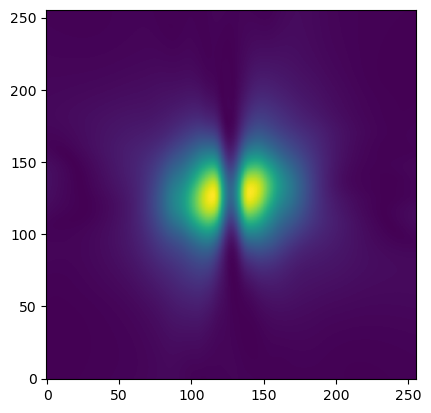

In [ ]:
plt.imshow(Jjnorm[:, :, 0].transpose(), origin='lower')

<matplotlib.image.AxesImage>

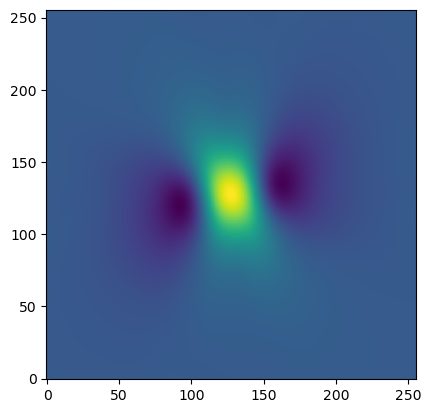

In [ ]:
plt.imshow(Bzz[:, :, 0].transpose(), origin='lower')

<matplotlib.image.AxesImage>

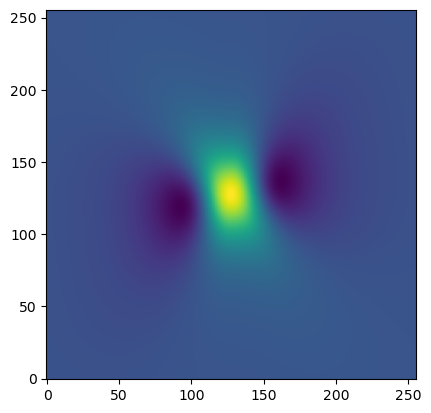

In [ ]:
plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower')

In [ ]:
jnp.linalg.norm(Bb, axis=-1).shape

(256, 256, 256)

In [ ]:
jnp.sum(Bb**2, axis=-1).shape

(256, 256, 256)

<matplotlib.image.AxesImage>

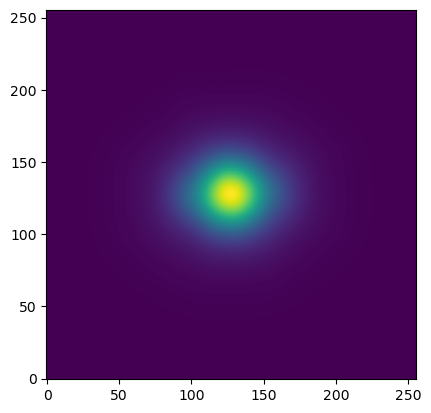

In [ ]:
plt.imshow(jnp.sum(Bb**2, axis=-1)[:, :, 0].transpose(), origin='lower')
#plt.imshow(Bxx[:, :, 0]**2+Byy[:, :, 0]**2+Bzz[:, :, 0]**2)

<matplotlib.image.AxesImage>

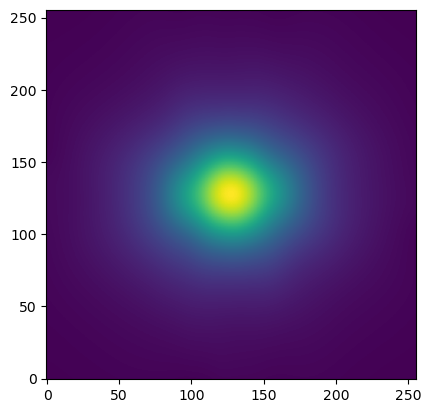

In [ ]:
plt.imshow(jnp.linalg.norm(Bb, axis=-1)[:, :, 0].transpose(), origin='lower')

In [ ]:
import pyvista as pv

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
x, y, z = jnp.meshgrid(jnp.squeeze(xx), jnp.squeeze(yy), jnp.squeeze(zz), indexing='ij')
points = np.vstack((x.ravel(), y.ravel(), z.ravel())).T
vectors = np.vstack((Bxx.ravel(), Byy.ravel(), Bzz.ravel())).T
pdata = pv.vector_poly_data(points, vectors)

In [ ]:
# p = pv.Plotter()
# p.show_bounds()
# p.add_mesh(pdata.outline())
# p.add_mesh(pdata)
# p.show()

In [ ]:
xmin, xmax, ymin, ymax, zmin, zmax = pdata.bounds
xsize, ysize, zsize = xmax-xmin, ymax-ymin, zmax-zmin
xcenter, ycenter, zcenter = (xmin+xmax)/2, (ymin+ymax)/2, (zmin+zmax)/2

In [ ]:
grid = pv.StructuredGrid(np.array(x), np.array(y), np.array(z))
grid['B'] = np.stack([Bxx, Byy, Bzz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
grid.active_vectors_name = 'B'
magnitude = np.linalg.norm(vectors, axis=-1)
grid['mag'] = magnitude
grid.active_scalars_name = 'mag'

In [ ]:
grid

StructuredGrid (0x7f2f9c532c20)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.000e+00
  Y Bounds:     0.000e+00, 2.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   256, 256, 256
  N Arrays:     2

In [ ]:
bottom_subset = (0, nx-1, 0, ny-1, 0, 0)
bottom = grid.extract_subset(bottom_subset).extract_surface()
bottom

PolyData (0x7f2f9c534d00)
  N Cells:    65025
  N Points:   65536
  N Strips:   0
  X Bounds:   0.000e+00, 2.000e+00
  Y Bounds:   0.000e+00, 2.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [ ]:
x_bottom = bottom.points[:, 0].reshape(nx, ny)
y_bottom = bottom.points[:, 1].reshape(nx, ny)
B_bottom = bottom['B'].reshape(nx, ny, 3)

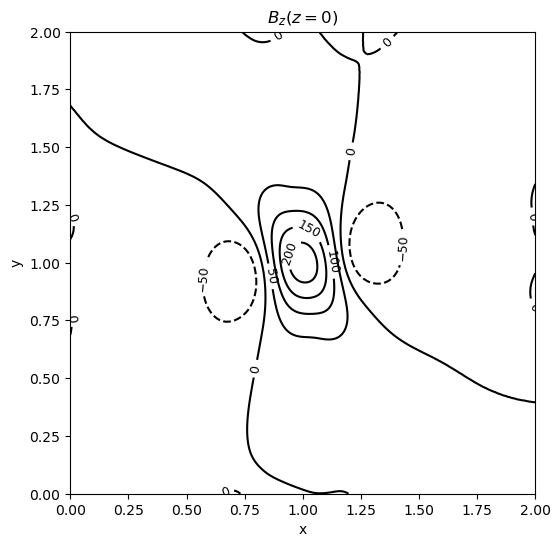

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.contour(x_bottom, y_bottom, B_bottom[:, :, 2], 
                    origin='lower', colors='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title(r"$B_z(z=0)$")
plt.show()

In [ ]:
co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(nx, ny, nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
ggrid = pv.StructuredGrid(x, y, z)
ggrid['B'] = grid['B']
ggrid.active_vectors_name = 'B'
magnitude = np.linalg.norm(grid['B'], axis=-1)
ggrid['mag'] = magnitude
ggrid.active_scalars_name = 'mag'

In [ ]:
ggrid

StructuredGrid (0x7f2f9c530940)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

In [ ]:
bottom_subset = (0, nx-1, 0, ny-1, 0, 0)
bottom = ggrid.extract_subset(bottom_subset).extract_surface()
bottom

PolyData (0x7f2f9c0fce20)
  N Cells:    65025
  N Points:   65536
  N Strips:   0
  X Bounds:   0.000e+00, 2.550e+02
  Y Bounds:   0.000e+00, 2.550e+02
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   4

In [ ]:
x_bottom = bottom.points[:, 0].reshape(nx, ny)
y_bottom = bottom.points[:, 1].reshape(nx, ny)
B_bottom = bottom['B'].reshape(nx, ny, 3)

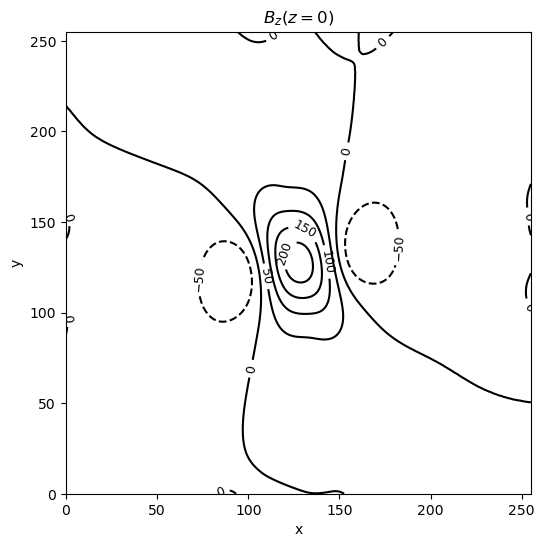

In [ ]:
plt.close()
fig, ax = plt.subplots(figsize=(6,6))
CS = plt.contour(x_bottom, y_bottom, B_bottom[:, :, 2], 
                    origin='lower', colors='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.clabel(CS, fontsize=9, inline=True)
ax.set_title(r"$B_z(z=0)$")
plt.show()

In [ ]:
from zpinn.pinn_nf2_visualization import draw_grid

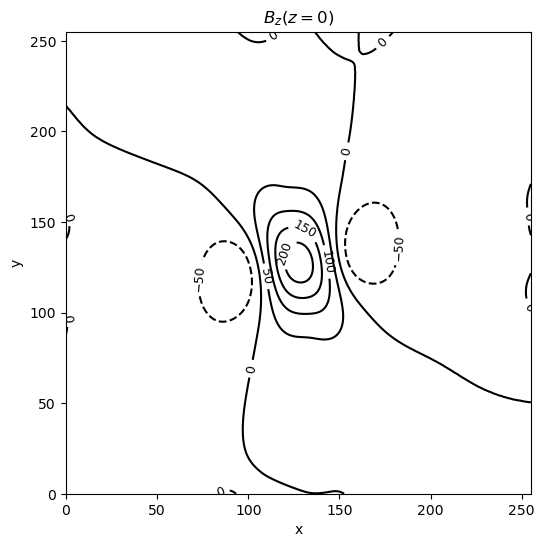

In [ ]:
aaa = draw_grid(ggrid)
aaa.plt_Bz()

In [ ]:
co_bounds = (0, nx-1, 0, ny-1, 0, nz-1)
co_coords = create_coordinates(co_bounds).reshape(-1, 3)
co_coord = co_coords.reshape(nx, ny, nz, 3)
x = co_coord[..., 0]
y = co_coord[..., 1]
z = co_coord[..., 2]
bgrid = pv.StructuredGrid(x, y, z)
# bgrid['B'] = b.grid['B']
bgrid['B'] = bv
bgrid.active_vectors_name = 'B'
# magnitude = np.linalg.norm(b.grid['B'], axis=-1)
magnitude = np.linalg.norm(bv, axis=-1)
bgrid['mag'] = magnitude
bgrid.active_scalars_name = 'mag'

In [ ]:
bgrid

StructuredGrid (0x7f30e4471300)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     0.000e+00, 2.550e+02
  Y Bounds:     0.000e+00, 2.550e+02
  Z Bounds:     0.000e+00, 2.550e+02
  Dimensions:   256, 256, 256
  N Arrays:     2

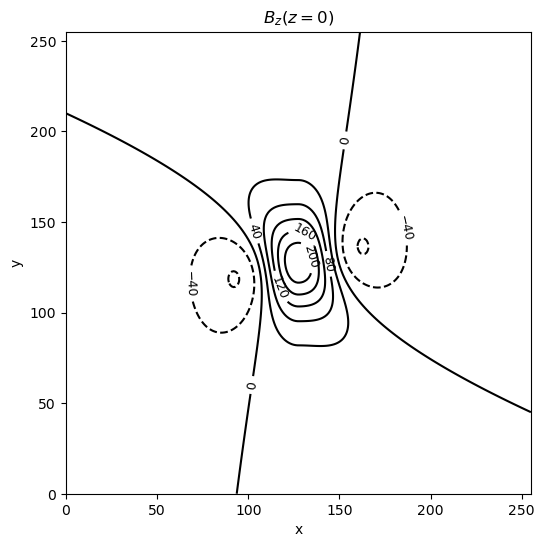

In [ ]:
bbb = draw_grid(bgrid)
bbb.plt_Bz()

In [ ]:
aaa.pv_streamline()

: 

: 

In [ ]:
bbb.pv_streamline()